In [79]:
import numpy as np
import pystan
from matplotlib import pyplot as plt
import matplotlib
import arviz as az

In [110]:
matplotlib.rcParams['figure.figsize'] = [15, 10]

### Loading the data

In [34]:
data = np.loadtxt('hw2data.txt', delimiter=' ', skiprows=1, usecols=(1,2,3,4))

In [3]:
print(data)
print(data.shape)

[[  4.23188397  11.60568902 -10.1579478  -11.35888827]
 [ -8.96470832   7.34716966 -11.80037894 -11.02594976]
 [-11.38825055  15.72067023  -8.81519721   6.83652085]
 ...
 [  1.11337095   8.82654073  -8.07744641   2.28778961]
 [  2.79768699  10.11172176  10.19950043  -9.95393532]
 [  2.89316293   4.01308     -9.93705343  -7.74189535]]
(1000, 4)


### Visualizing the data distribution

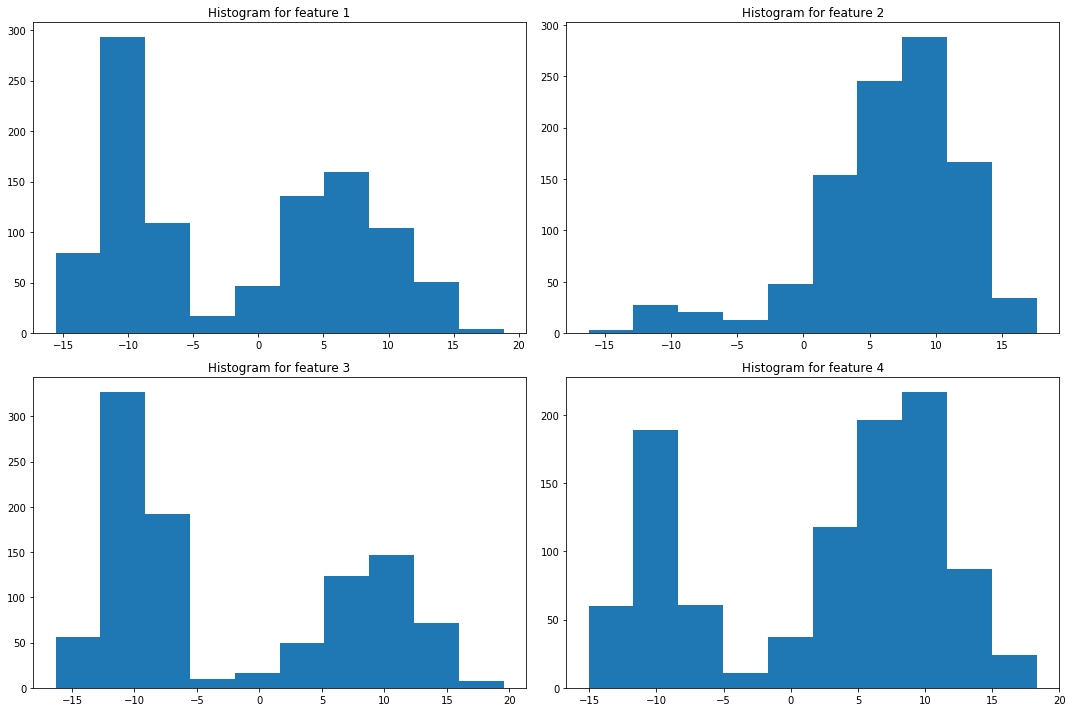

In [83]:
def draw_histograms(data, variables, n_rows, n_cols):
    fig=plt.figure()
    for i in variables:
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        plt.hist(data[:,i])
        ax.set_title("Histogram for feature "+str(i+1))
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(data, range(4), 2, 2)

It is clear from the histograms that each of the features are a mixture of 2 or 3 hidden states.

### The first Stan model

In [48]:
model = """
data {
    int N; // sample size
    int D; // dimension of observed vars
    int K; // number of latent groups
    vector[D] y[N]; // data
}
parameters {
    ordered[K] mu; // locations of hidden states
    vector<lower = 0>[K] sigma; // variances of hidden states
    simplex[K] theta[D]; // mixture components
}
model {
    vector[K] obs[D];

    // priors
    for(k in 1:K){
        mu[k] ~ normal(0,10);
        sigma[k] ~ inv_gamma(1,1);
    }

    for(d in 1:D){
        theta[d] ~ dirichlet(rep_vector(2.0, K));
    }

    // likelihood
    for(d in 1:D){
        for(i in 1:N) {
            for(k in 1:K) {
                obs[d][k] = log(theta[d][k]) + normal_lpdf(y[i][d] | mu[k], sigma[k]);
            }
            target += log_sum_exp(obs[d]);
        }
    }
}
"""

In [50]:
# Put our data in a dictionary
data_dict = {'N':data.shape[0], 'D':data.shape[1], 'K':3, 'y':data}

In [49]:
# Compile the model
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7dbd1b307fac3a2ff79113705cbf8846 NOW.


In [28]:
# Train the model and generate samples
fit = sm.sampling(data=data_dict, warmup = 500, iter = 1000, chains = 4, thin = 1, seed=101)

In [30]:
print(fit)

Inference for Stan model: anon_model_7dbd1b307fac3a2ff79113705cbf8846.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      -10.14    0.08   0.17 -10.59 -10.22 -10.08 -10.02  -9.95      5   1.35
mu[2]        -2.1    5.39   7.63 -10.02  -9.78  -2.56   5.56   6.21      2  21.71
mu[3]        8.73    0.85   1.21    7.4   7.54   8.45   9.93  10.38      2    6.4
sigma[1]     1.99  2.8e-3   0.09   1.79   1.96    2.0   2.04   2.17    990   1.02
sigma[2]     2.94    0.65   0.93   1.79   2.02   2.85   3.87   4.14      2    5.6
sigma[3]     3.57    0.39   0.57   2.79   3.01    3.7   4.12   4.23      2   5.61
theta[1,1]   0.39    0.07   0.11   0.14   0.31   0.46   0.48   0.51      3   1.85
theta[2,1]   0.04    0.01   0.02 7.8e-3   0.03   0.04   0.05   0.07      3   1.84
theta[3,1]   0.44     0.1   0.16   0.11   0.29   0.54   0.58    0.6      2 

Clearly, from the `Rhat` and `n_eff` above, we can see that the sampling is inefficient for almost all the parameters (except perhaps `sigma[1]`. Below, we will try out several different configurations by changing the priors of the sampling settings.

### Exploring Stan model configurations

We have several configuration options to play around with. Specifically, we will tweak the following hyperparameters:
1. Prior hyperparameters in the model
2. Prior distribution
3. Number of states in the mixture.

In [84]:
model = """
data {
    int N; // sample size
    int D; // dimension of observed vars
    int K; // number of latent groups
    vector[D] y[N]; // data
}
parameters {
    ordered[K] mu; // locations of hidden states
    vector<lower = 0>[K] sigma; // variances of hidden states
    simplex[K] theta[D]; // mixture components
}
model {
    vector[K] obs[D];

    // priors
    for(k in 1:K){
        mu[k] ~ normal(0,100);
        sigma[k] ~ inv_gamma(1,1);
    }
    mu[1] ~ normal(-10,10);
    mu[2] ~ normal(10,10);

    for(d in 1:D){
        theta[d] ~ dirichlet(rep_vector(2.0, K));
    }

    // likelihood
    for(d in 1:D){
        for(i in 1:N) {
            for(k in 1:K) {
                obs[d][k] = log(theta[d][k]) + normal_lpdf(y[i][d] | mu[k], sigma[k]);
            }
            target += log_sum_exp(obs[d]);
        }
    }
}
"""

In [85]:
# Compile the model
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ddfd72e76744462fe1f2a5f61bd939ff NOW.


In [86]:
# Train the model and generate samples
fit = sm.sampling(data=data_dict, warmup = 500, iter = 1000, chains = 4, thin = 1, seed=101)
print(fit)

Inference for Stan model: anon_model_ddfd72e76744462fe1f2a5f61bd939ff.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      -10.13    0.07   0.16 -10.58  -10.2 -10.08 -10.02  -9.94      5   1.33
mu[2]       -2.11    5.42   7.67 -10.03  -9.83  -2.26   5.58   6.25      2  22.46
mu[3]        8.74    0.85   1.22    7.4   7.54   8.42   9.94  10.39      2   6.29
sigma[1]     1.99  5.4e-3   0.09   1.76   1.95    2.0   2.04   2.17    301   1.03
sigma[2]     2.95    0.64   0.92   1.82   2.04   2.97   3.86   4.14      2   5.73
sigma[3]     3.56    0.39   0.56   2.77   3.01   3.68   4.11   4.22      2   5.35
theta[1,1]   0.39    0.07   0.12   0.13   0.29   0.45   0.49   0.51      3   1.93
theta[2,1]   0.04    0.01   0.02 5.9e-3   0.02   0.04   0.05   0.07      3   1.86
theta[3,1]   0.43    0.11   0.17   0.09   0.28   0.55   0.58    0.6      3 

##### Trace plots for different prior parameters 

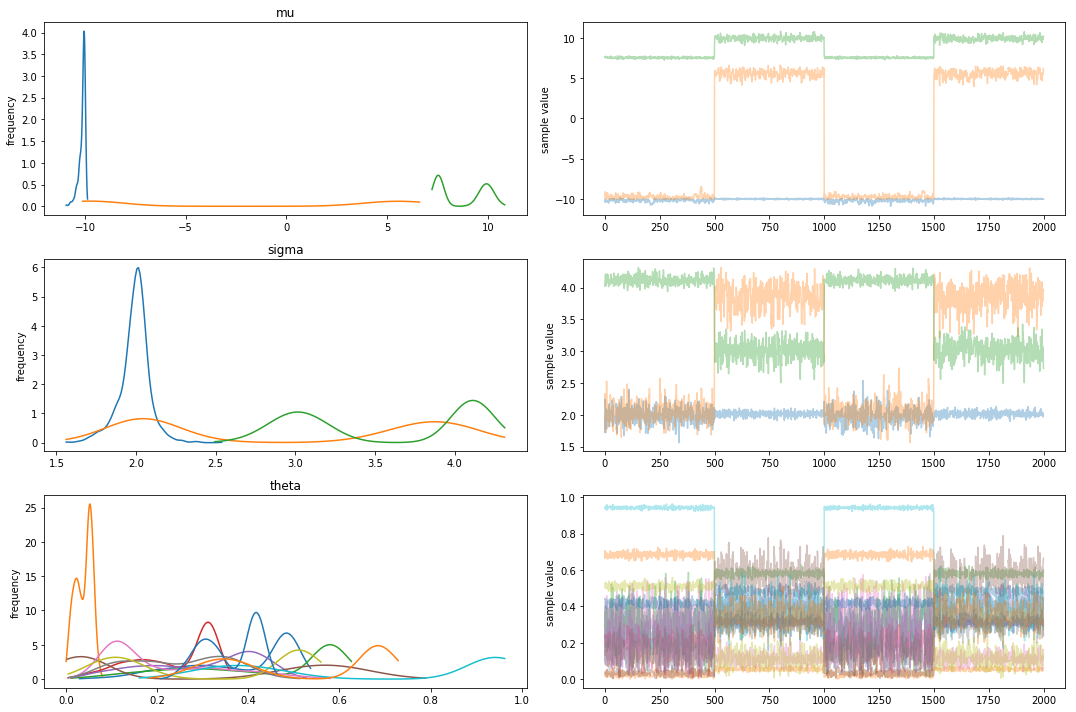

In [87]:
fit.plot()
plt.tight_layout()
plt.show()

Some observations:
1. Changing parameters to the priors for mu and sigma do not seem to help too much.
2. Tried sampling for more iterations with a longer warmup period, but didn't help.
3. Performance degradation on using non-informative prior for mu.

##### Using 2 Gaussians in the mixture

In [35]:
# Put our data in a dictionary
data_dict = {'N':data.shape[0], 'D':data.shape[1], 'K':2, 'y':data}

From the feature histograms, it seems using different `mu_0` for the `mu` parameters might help. This gives the following sampling.

In [36]:
# Train the model and generate samples
fit = sm.sampling(data=data_dict, warmup = 500, iter = 1000, chains = 4, thin = 1, seed=101)
print(fit)

Inference for Stan model: anon_model_fcc05235932d6e213347b8d032ea15a9.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]       -6.98    3.73   5.27 -10.13 -10.05  -10.0  -3.56   2.37      2  53.47
mu[2]        6.19    1.65   2.33    1.9   4.74    7.5   7.57   7.68      2  21.09
sigma[1]     3.31    1.58   2.24   1.95    2.0   2.04   4.49   7.48      2  19.52
sigma[2]     5.55    1.76   2.48   4.01   4.09   4.14   7.15  10.04      2  29.62
theta[1,1]   0.37    0.14    0.2 9.3e-3   0.32   0.48   0.49   0.52      2  10.78
theta[2,1]   0.28    0.28    0.4   0.04   0.05   0.06   0.53   0.99      2  33.14
theta[3,1]   0.44    0.17   0.25 3.4e-3   0.27   0.57   0.59   0.61      2  17.53
theta[4,1]   0.27    0.06   0.09   0.04   0.28   0.31   0.32   0.34      2    2.3
theta[1,2]   0.63    0.14    0.2   0.48   0.51   0.52   0.68   0.99      2 

Seems evident from the above that using 2 Gaussians in the mixture degrades the mixing. 

##### Using different prior distributions

In [46]:
model = """
data {
    int N; // sample size
    int D; // dimension of observed vars
    int K; // number of latent groups
    vector[D] y[N]; // data
}
parameters {
    ordered[K] mu; // locations of hidden states
    vector<lower = 0>[K] sigma; // variances of hidden states
    simplex[K] theta[D]; // mixture components
}
model {
    vector[K] obs[D];

    // priors
    for(k in 1:K){
        mu[k] ~ cauchy(0,10);
        sigma[k] ~ inv_gamma(1,1);
    }

    for(d in 1:D){
        theta[d] ~ dirichlet(rep_vector(2.0, K));
    }

    // likelihood
    for(d in 1:D){
        for(i in 1:N) {
            for(k in 1:K) {
                obs[d][k] = log(theta[d][k]) + normal_lpdf(y[i][d] | mu[k], sigma[k]);
            }
            target += log_sum_exp(obs[d]);
        }
    }
}
"""

In [45]:
# Train the model and generate samples
fit = sm.sampling(data=data_dict, warmup = 500, iter = 1000, chains = 4, thin = 1, seed=101)
print(fit)

Inference for Stan model: anon_model_e00be93306f3aa0393b5f46741da1951.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      -10.09    0.07   0.15 -10.56 -10.11 -10.05  -10.0  -9.94      5   1.38
mu[2]        1.71    4.68   6.63  -9.99  -3.08   5.34   5.76   6.32      2   16.9
mu[3]        9.32    0.73   1.06   7.43   8.32    9.8  10.04   10.4      2   4.66
sigma[1]      2.0  4.8e-3   0.07   1.81   1.97    2.0   2.04   2.12    210   1.04
sigma[2]      3.4    0.56   0.81   1.84   2.83   3.78   3.96   4.18      2   4.69
sigma[3]      3.3    0.33   0.49   2.78   2.97   3.09   3.79    4.2      2   4.11
theta[1,1]   0.44    0.06   0.09   0.17   0.45   0.48   0.49   0.51      3   2.21
theta[2,1]   0.05  9.0e-3   0.02   0.01   0.04   0.05   0.06   0.07      3   1.79
theta[3,1]    0.5    0.09   0.14   0.14   0.53   0.57   0.59   0.61      2 

A Cauchy prior for the `mu` parameters seems to mix slightly better than the Normal prior.

### Variational inference

PyStan has 2 algorithms available for variational inference: `meanfield` and `fullrank`. We will first summarize these methods.
1. `meanfield`: This is same as the mean field approximation discussed in class. In particular, this algorithm finds the set of independent normal distributions in the unconstrained space that — when transformed into the constrained space — most closely approximate the posterior distribution. Then it draws repeatedly from these independent normal distributions and transforms them into the constrained space.
2. `fullrank`: Finds the multivariate normal distribution in the constrained space that — when transformed into the constrained space — most closely approximates the posterior distribution. Then it draws repeatedly from this multivariate normal distribution and transforms the draws into the constrained space. 

In [73]:
result_mf = sm.vb(data=data_dict, algorithm='meanfield', iter = 1000, seed=101)

In [74]:
result_mf.keys()

odict_keys(['args', 'inits', 'sampler_params', 'sampler_param_names', 'mean_pars', 'mean_par_names'])

In [76]:
result_fr = sm.vb(data=data_dict, algorithm='fullrank', iter = 1000, seed=101)

In [88]:
for x,y,z in zip(result_fr['mean_par_names'],result_mf['mean_pars'],result_fr['mean_pars']):
    print(x,y,z)

mu[1] -10.008987898707133 1.1880787337958294
mu[2] 6.411010043708462 1.4987195705937306
mu[3] 10.270045346516406 1.7562461717705389
sigma[1] 1.9912831505184483 9.05105139032095
sigma[2] 3.89055310925907 15.873433614834953
sigma[3] 3.0412072876509986 12.627738628351963
theta[1,1] 0.49915853682767364 0.9928943720651939
theta[2,1] 0.052980760340958846 0.9903122278964785
theta[3,1] 0.5658487592162998 0.994482442860319
theta[4,1] 0.32919649967422643 0.9930261005349788
theta[1,2] 0.46012371656292506 0.003838462525177358
theta[2,2] 0.6713040613065955 0.00460850230937595
theta[3,2] 0.14199446498319104 0.002999698216507043
theta[4,2] 0.4011612818553285 0.004067062052313689
theta[1,3] 0.040717746609401306 0.003267165409628711
theta[2,3] 0.27571517835244563 0.005079269794145503
theta[3,3] 0.29215677580050914 0.0025178589231740077
theta[4,3] 0.269642218470445 0.0029068374127075606


From the mean of the posteriors obtained above, it appears that the Mean Field algorithm works much better than the Full Rank method. This is counter-intuitive since `meanfield` makes a stronger assumption of feature independence for sampling, whereas `fullrank` makes no such assumptions.

We can plot the density estimate as follows.

In [94]:
# library and dataset
import seaborn as sns
def plot_density(data):
    p1=sns.kdeplot(data[0], shade=True, color="r")
    p2=sns.kdeplot(data[1], shade=True, color="b")
    p3=sns.kdeplot(data[2], shade=True, color="g")

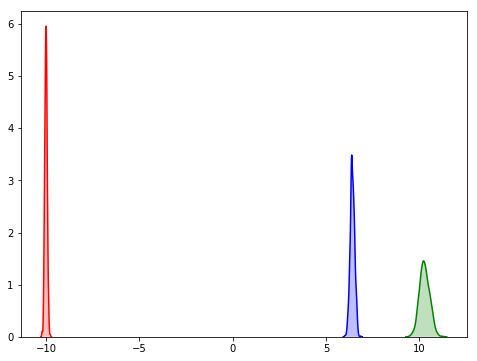

In [98]:
data_plt = [result_mf['sampler_params'][0],result_mf['sampler_params'][1],result_mf['sampler_params'][2]]
plot_density(data_plt)

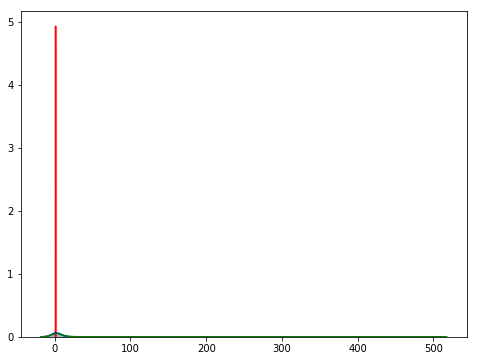

In [100]:
data_plt = [result_fr['sampler_params'][0],result_fr['sampler_params'][1],result_fr['sampler_params'][2]]
plot_density(data_plt)

Using these mean values for the posterior obtained using Mean Field variational inference, we can go back to the MCMC sampling and use them for the prior. Also, from earlier exploration, we found that the Cauchy prior on `mu` worked better than a Normal prior.

In [107]:
model = """
data {
    int N; // sample size
    int D; // dimension of observed vars
    int K; // number of latent groups
    vector[D] y[N]; // data
}
parameters {
    ordered[K] mu; // locations of hidden states
    vector<lower = 0>[K] sigma; // variances of hidden states
    simplex[K] theta[D]; // mixture components
}
model {
    vector[K] obs[D];

    // priors
    for(k in 1:K){
        //mu[k] ~ normal(0,100);
        sigma[k] ~ inv_gamma(1,1);
    }
    mu[1] ~ cauchy(-10.008987898707133, 1);
    mu[2] ~ cauchy(6.411010043708462, 1);
    mu[3] ~ cauchy(10.270045346516406, 1);

    for(d in 1:D){
        theta[d] ~ dirichlet(rep_vector(2.0, K));
    }

    // likelihood
    for(d in 1:D){
        for(i in 1:N) {
            for(k in 1:K) {
                obs[d][k] = log(theta[d][k]) + normal_lpdf(y[i][d] | mu[k], sigma[k]);
            }
            target += log_sum_exp(obs[d]);
        }
    }
}
"""

In [108]:
# Compile the model
sm = pystan.StanModel(model_code=model)
# Train the model and generate samples
fit = sm.sampling(data=data_dict, warmup = 500, iter = 1000, chains = 4, thin = 1, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_152ce584d5734e5217874a55acbc5163 NOW.


Inference for Stan model: anon_model_152ce584d5734e5217874a55acbc5163.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      -10.07    0.05   0.11 -10.42  -10.1 -10.05 -10.01  -9.93      5   1.31
mu[2]        1.86    4.76   6.74 -10.01  -2.99   5.62   5.95   6.39      2  19.55
mu[3]        9.39    0.75   1.09   7.44   8.37   9.91  10.11  10.47      2   5.04
sigma[1]     2.01  1.8e-3   0.07   1.84   1.97   2.01   2.04   2.14   1557   1.02
sigma[2]     3.44    0.57   0.83   1.87   2.81   3.85   3.99   4.19      2   5.34
sigma[3]     3.27    0.35    0.5   2.73   2.92   3.05   3.76   4.19      2   4.26
theta[1,1]   0.44    0.06    0.1   0.17   0.45   0.48   0.49   0.51      3   2.08
theta[2,1]   0.05  8.7e-3   0.02 9.7e-3   0.04   0.05   0.06   0.07      3   1.71
theta[3,1]   0.51    0.09   0.14   0.14   0.53   0.57   0.59   0.61      2 

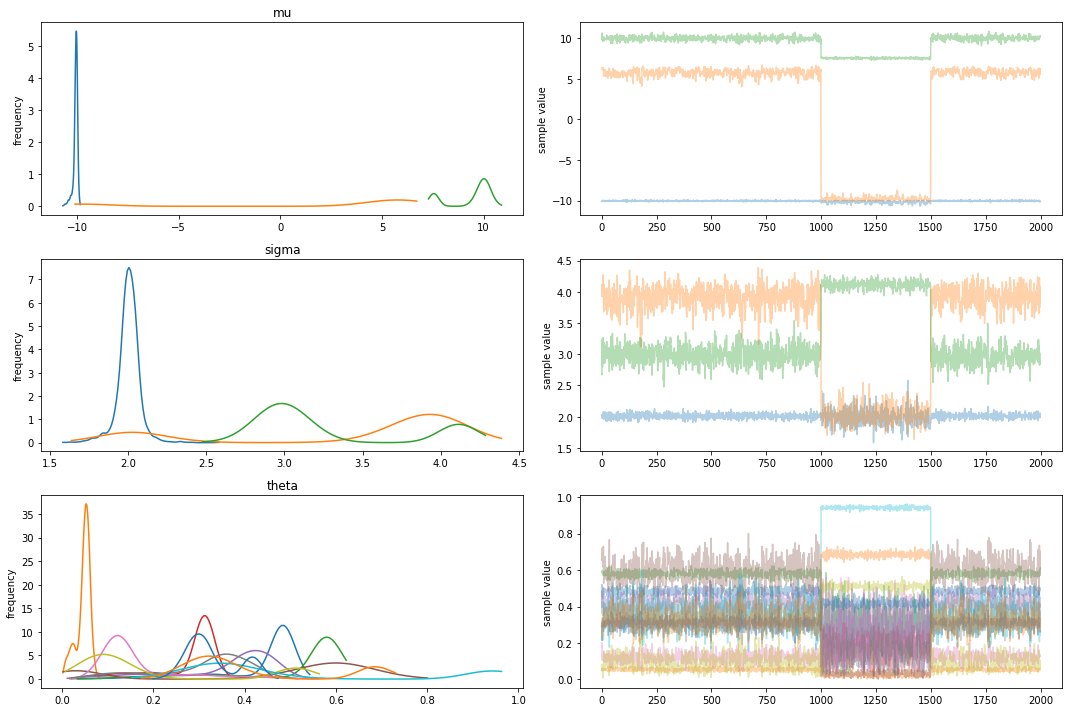

In [111]:
fit.plot()
plt.tight_layout()
plt.show()

Comparing the trace plots here with those obtained earlier, we can see that 3 of the 4 chains mixed well for all of the parameters, while just 1 chain was the outlier. In the earlier exploration, only 2 of the 4 chains mixed well. This is definitely an improvement, although the `Rhat` and `n_eff` values don't appear to have changed too much.